## FinViz:

In [1]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer

finwiz_url = 'https://finviz.com/quote.ashx?t='

In [2]:
news_tables = {}
tickers = ['AMZN', 'TSLA', 'GOOG']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [3]:
# Read one single day of headlines for 'AMZN' 
amzn = news_tables['AMZN']
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 3:
        break

Dow Jones Futures: Amazon, Apple Fuel Stock Market Rally; Nike Soars On Earnings, While Tesla Dives 7% On Battery Day
Sep-22-20 08:56PM  
A $50 Phone is Ambani's Weapon to Dominate India Telecom Market
08:20PM  
GLOBAL MARKETS-Asian stocks set to gain after Wall Street's tech bounce
07:57PM  
Amazon Chases Peloton With Prime Bike. Peloton Is Still Ahead of the Pack, One Analyst Says.
07:53PM  


In [7]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])

In [5]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,AMZN,2020-09-22,08:56PM,"Dow Jones Futures: Amazon, Apple Fuel Stock Ma...",0.000,0.918,0.082,0.1779
1,AMZN,2020-09-22,08:20PM,A $50 Phone is Ambani's Weapon to Dominate Ind...,0.316,0.684,0.000,-0.4019
2,AMZN,2020-09-22,07:57PM,GLOBAL MARKETS-Asian stocks set to gain after ...,0.000,0.746,0.254,0.5267
3,AMZN,2020-09-22,07:53PM,Amazon Chases Peloton With Prime Bike. Peloton...,0.000,0.898,0.102,0.1779
4,AMZN,2020-09-22,07:24PM,GameStop Rises Sharply on Disclosure of Talks ...,0.000,1.000,0.000,0.0000


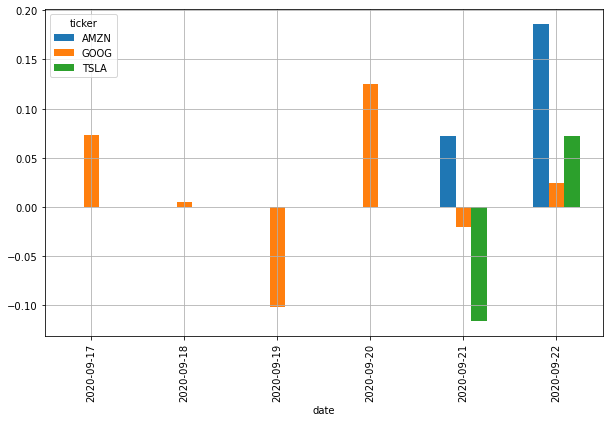

In [6]:
plt.rcParams['figure.figsize'] = [10, 6]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()

In [8]:
amzn_data = pd.read_csv('~/lighthouse-data-notes/AMZN.csv')

In [17]:
amzn_data.shape

(253, 9)

In [9]:
amzn_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-09-23,1777.000000,1792.699951,1767.319946,1785.300049,1785.300049,2922300
1,2019-09-24,1790.609985,1795.709961,1735.550049,1741.609985,1741.609985,4616000
2,2019-09-25,1747.359985,1773.000000,1723.000000,1768.329956,1768.329956,3493200
3,2019-09-26,1762.790039,1763.369995,1731.500000,1739.839966,1739.839966,3536800
4,2019-09-27,1748.000000,1749.119995,1713.819946,1725.449951,1725.449951,3907200


In [11]:
amzn_data['Date'] = pd.to_datetime(amzn_data['Date'])

In [18]:
amzn_data['MA10'] = amzn_data['Adj Close'].rolling(10).mean()
amzn_data['MA50'] = amzn_data['Adj Close'].rolling(50).mean()
amzn_data['MA200'] = amzn_data['Adj Close'].rolling(200).mean()

In [24]:
plt.rcParams['figure.figsize'] = [10, 6]
amzn_data[['Adj Close', 'MA10', 'MA50']].plot(label='AMZN', title='Amazon Stock')

TypeError: '('Date', ['Adj Close', 'MA10', 'MA50'])' is an invalid key

<AxesSubplot:title={'center':'Volume Traded'}>

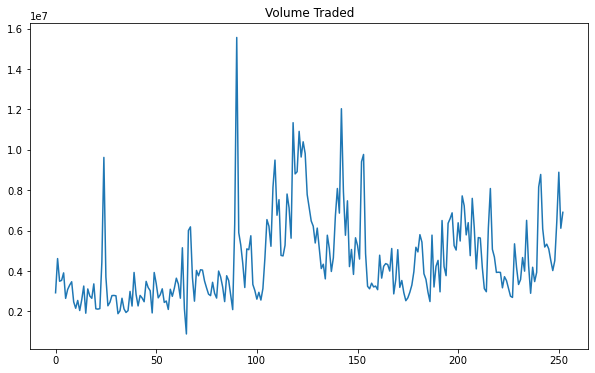

In [13]:
amzn_data['Volume'].plot(label='AMZN', title='Volume Traded')